<a href="https://colab.research.google.com/github/dushyant1singh1/Blog-Application/blob/master/main_project_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Skin Lesion Prediction with Multi Layer Sequential Model, Various optimizers and Performance Comparision



In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from PIL import Image
from matplotlib.image import imread
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
import pandas as pd
from keras.utils import plot_model
from sklearn.metrics import classification_report,multilabel_confusion_matrix
from yellowbrick.classifier import ClassificationReport
import pandas as pd

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Total train dataset has 1590 images<br>
We will split the train labels according to the numbers of each class
Classes:<br>
  0 - seborrheic keratosis (476 images)<br>
  1 - melanoma (595 images)<br>
  2 - nevus (519 images)<br>

Dataset is available in google drive folder 'data' 

In the dataset not all images are of same size<br>
For that we have to preprocess all the images<br>
We will use open cv library cv2 for this<br>
down below is demonstration of how the resize will affect the image

In [2]:
data_url="/content/drive/My Drive/train"
val_url="/content/drive/My Drive/val"
test_url="/content/drive/My Drive/test"
train_data=tf.keras.preprocessing.image_dataset_from_directory(data_url,image_size=(256,256),batch_size=40,validation_split=0.1,subset='training',seed=123)
val_data=tf.keras.preprocessing.image_dataset_from_directory(data_url,image_size=(256,256),subset='validation',batch_size=1,validation_split=0.1,seed=123)
# test_data=tf.keras.preprocessing.image_dataset_from_directory(test_url,image_size=(256,256))

Found 1590 files belonging to 3 classes.
Using 1431 files for training.
Found 1590 files belonging to 3 classes.
Using 159 files for validation.


In [30]:
test_data_li=[]
test_label_li=[]

li=['melanoma','nevus','seb']
for folder in li:
  test_data_dir=os.listdir(test_url+'/'+folder)
  #print(test_data_dir)
  for name in test_data_dir:
    path=test_url+'/'+folder+'/'+name
    image=cv2.imread(path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(256,256),interpolation=cv2.INTER_NEAREST)
    test_data_li.append(image)
    if folder=='melanoma':
      test_label_li.append(0)
    elif folder=='nevus':
      test_label_li.append(1)
    else :
      test_label_li.append(2)
test_data_arr=np.array(test_data_li)
test_label_arr=np.array(test_label_li)

In [4]:
print(len(test_data_li))
print(len(test_label_li))
print(test_label_li)

36
36
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [5]:
optimizers=['sgd','rmsprop','adam','adagrad','adadelta']
data_classes=train_data.class_names 

Taking a look at the dataset images

In [8]:
for data,label in train_data:
  print(data.shape)
  print(label)
  break

(40, 256, 256, 3)
tf.Tensor(
[0 0 0 0 2 1 2 0 1 1 1 1 0 0 0 0 0 1 1 2 0 1 0 2 2 2 0 2 1 2 2 1 1 0 2 2 0
 2 0 1], shape=(40,), dtype=int32)


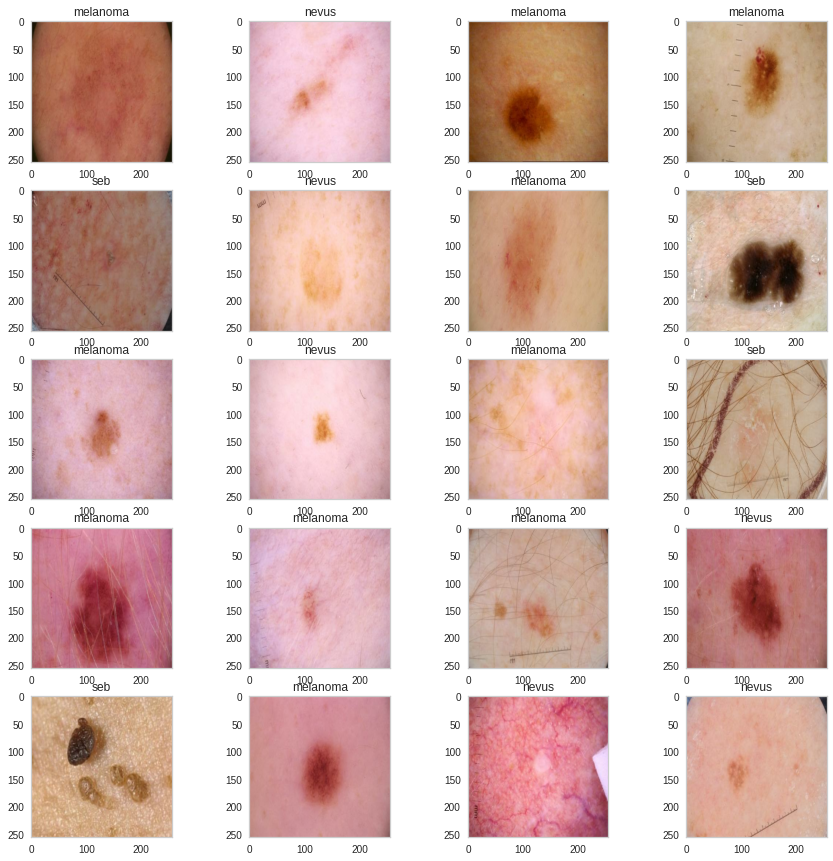

In [13]:
plt.figure(figsize=(15,15))
for data, label in train_data:
  for i in range(20):
    plt.subplot(5,4,i+1)
    plt.grid(False)
    plt.imshow(data[i]/255,cmap=plt.cm.binary)
    plt.title(data_classes[label[i]])
  break

In [19]:
def buildingModel(opt):
  numclass=3
  model = keras.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1./255),
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.Conv2D(64,1,activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64,2,activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32,2,activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32,2,activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32,2,activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    #keras.layers.BatchNormalization(),
    keras.layers.Dropout(.2),
    keras.layers.Flatten(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(numclass,activation='softmax')
  ]
  )
  model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,metrics=['accuracy'])
   
  return model

In [25]:
def gpu(model,epoch):
  with tf.device('/device:GPU:0'):
      callback=keras.callbacks.EarlyStopping(monitor='loss',patience=10)
      hist = model.fit(train_data,validation_data=val_data,epochs=epoch,callbacks=[callback])
      model_df=pd.DataFrame(hist.history)
      model_df['epoch']=hist.epoch   
  return model,model_df

In [15]:
def plotting(model_df):
  plt.figure(1)
  plt.plot(model_df['epoch'],model_df['loss'],label='training loss')
  plt.plot(model_df['epoch'],model_df['val_loss'],label='validation loss')
  plt.legend()
  plt.figure(2)
  plt.plot(model_df['epoch'],model_df['accuracy'],label='training accuracy')
  plt.plot(model_df['epoch'],model_df['val_accuracy'],label='validation accuracy')
  plt.legend()


In [16]:
def discretePredictions(predictions):
  experiment_predict=[]
  for li in predictions:
    if max(li)==li[0]:
      experiment_predict.append(0)
    elif max(li)==li[1]:
      experiment_predict.append(1)
    else:
      experiment_predict.append(2)
  return experiment_predict

**SGD - Stochastic Gradient Descent**
Advantages: 

In [17]:
epochs=40

In [26]:
model_sgd=buildingModel(optimizers[0])#optimizers = sgd
nmodel_sgd,model_df_sgd=gpu(model_sgd,epochs)
#plot_model(nmodel_sgd,to_file='/content/drive/My Drive/model.png',show_shapes=True)

Epoch 1/40
36/36 [==============================] - 7s 199ms/step - loss: 1.0999 - accuracy: 0.2949 - val_loss: 1.0980 - val_accuracy: 0.3396
Epoch 2/40
36/36 [==============================] - 7s 195ms/step - loss: 1.0993 - accuracy: 0.3026 - val_loss: 1.0976 - val_accuracy: 0.4277
Epoch 3/40
36/36 [==============================] - 7s 194ms/step - loss: 1.0989 - accuracy: 0.3263 - val_loss: 1.0975 - val_accuracy: 0.4025
Epoch 4/40
36/36 [==============================] - 7s 194ms/step - loss: 1.0983 - accuracy: 0.3725 - val_loss: 1.0975 - val_accuracy: 0.4025
Epoch 5/40
36/36 [==============================] - 7s 194ms/step - loss: 1.0981 - accuracy: 0.3711 - val_loss: 1.0974 - val_accuracy: 0.4025
Epoch 6/40
36/36 [==============================] - 7s 195ms/step - loss: 1.0978 - accuracy: 0.3711 - val_loss: 1.0972 - val_accuracy: 0.4025
Epoch 7/40
36/36 [==============================] - 7s 193ms/step - loss: 1.0976 - accuracy: 0.3711 - val_loss: 1.0971 - val_accuracy: 0.4025
Epoch 

In [32]:
results=model_sgd.evaluate(test_data_arr,test_label_arr)
predictions=model_sgd.predict(test_data_arr)
discrete_predict_li_sgd=discretePredictions(predictions)
print('\n\n\t\t ----- Classification Report -----')
print(classification_report(test_label_li,discrete_predict_li_sgd,target_names=data_classes))
print('\n\nConfusion Matrix Individual for Each class')
print(multilabel_confusion_matrix(test_label_li,discrete_predict_li_sgd))

2/2 [==============================] - 0s 34ms/step - loss: 1.0980 - accuracy: 0.3333


		 ----- Classification Report -----
              precision    recall  f1-score   support

    melanoma       0.33      1.00      0.50        12
       nevus       0.00      0.00      0.00        12
         seb       0.00      0.00      0.00        12

    accuracy                           0.33        36
   macro avg       0.11      0.33      0.17        36
weighted avg       0.11      0.33      0.17        36



Confusion Matrix Individual for Each class
[[[ 0 24]
  [ 0 12]]

 [[24  0]
  [12  0]]

 [[24  0]
  [12  0]]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


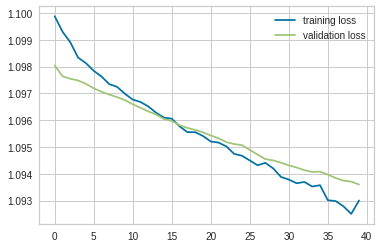

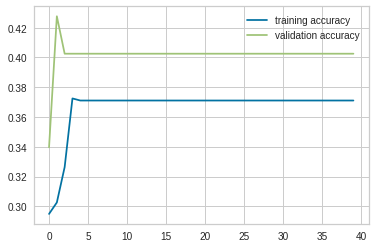

In [33]:
plotting(model_df_sgd)

**RMSPROP**

Epoch 1/40
36/36 [==============================] - 7s 198ms/step - loss: 1.0985 - accuracy: 0.3697 - val_loss: 1.1082 - val_accuracy: 0.4025
Epoch 2/40
36/36 [==============================] - 7s 195ms/step - loss: 1.0935 - accuracy: 0.3690 - val_loss: 1.0950 - val_accuracy: 0.2704
Epoch 3/40
36/36 [==============================] - 7s 193ms/step - loss: 1.0878 - accuracy: 0.3760 - val_loss: 1.0525 - val_accuracy: 0.5094
Epoch 4/40
36/36 [==============================] - 7s 196ms/step - loss: 1.0503 - accuracy: 0.4235 - val_loss: 1.0096 - val_accuracy: 0.5346
Epoch 5/40
36/36 [==============================] - 7s 195ms/step - loss: 1.0073 - accuracy: 0.4745 - val_loss: 0.9360 - val_accuracy: 0.5912
Epoch 6/40
36/36 [==============================] - 7s 202ms/step - loss: 0.9719 - accuracy: 0.5192 - val_loss: 1.0227 - val_accuracy: 0.3962
Epoch 7/40
36/36 [==============================] - 7s 193ms/step - loss: 0.9681 - accuracy: 0.5248 - val_loss: 1.0309 - val_accuracy: 0.5094
Epoch 

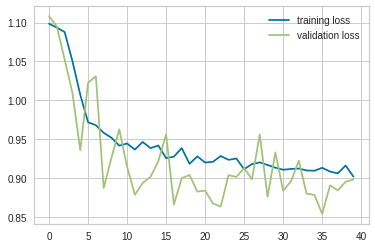

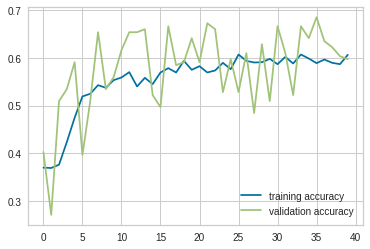

In [35]:
model_rmsprop=buildingModel(optimizers[1])#optimizers = rmsprop
nmodel_rmsprop,model_df_rmsprop=gpu(model_rmsprop,epochs)
plotting(model_df_rmsprop)

In [36]:
results=model_rmsprop.evaluate(test_data_arr,test_label_arr)
predictions=model_rmsprop.predict(test_data_arr)
discrete_predict_li_rmsprop=discretePredictions(predictions)
print('\n\n\t\t ----- Classification Report -----')
print(classification_report(test_label_li,discrete_predict_li_rmsprop,target_names=data_classes))
print('\n\nConfusion Matrix Individual for Each class')
print(multilabel_confusion_matrix(test_label_li,discrete_predict_li_rmsprop))

2/2 [==============================] - 0s 5ms/step - loss: 0.8577 - accuracy: 0.6667


		 ----- Classification Report -----
              precision    recall  f1-score   support

    melanoma       0.56      0.42      0.48        12
       nevus       0.53      0.67      0.59        12
         seb       0.92      0.92      0.92        12

    accuracy                           0.67        36
   macro avg       0.67      0.67      0.66        36
weighted avg       0.67      0.67      0.66        36



Confusion Matrix Individual for Each class
[[[20  4]
  [ 7  5]]

 [[17  7]
  [ 4  8]]

 [[23  1]
  [ 1 11]]]


**ADAM**

Epoch 1/40
36/36 [==============================] - 7s 199ms/step - loss: 1.0945 - accuracy: 0.3641 - val_loss: 1.1028 - val_accuracy: 0.2579
Epoch 2/40
36/36 [==============================] - 7s 193ms/step - loss: 1.0917 - accuracy: 0.3529 - val_loss: 1.0895 - val_accuracy: 0.4025
Epoch 3/40
36/36 [==============================] - 7s 194ms/step - loss: 1.0514 - accuracy: 0.4186 - val_loss: 0.9097 - val_accuracy: 0.6604
Epoch 4/40
36/36 [==============================] - 7s 195ms/step - loss: 1.0042 - accuracy: 0.4808 - val_loss: 1.0128 - val_accuracy: 0.4403
Epoch 5/40
36/36 [==============================] - 7s 197ms/step - loss: 0.9467 - accuracy: 0.5556 - val_loss: 0.9394 - val_accuracy: 0.5283
Epoch 6/40
36/36 [==============================] - 7s 200ms/step - loss: 0.9378 - accuracy: 0.5639 - val_loss: 0.9405 - val_accuracy: 0.6038
Epoch 7/40
36/36 [==============================] - 7s 194ms/step - loss: 0.9358 - accuracy: 0.5618 - val_loss: 0.8856 - val_accuracy: 0.6478
Epoch 

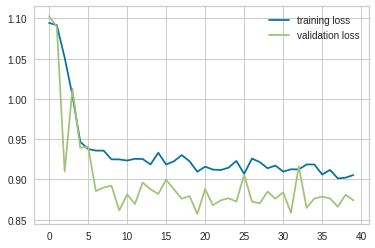

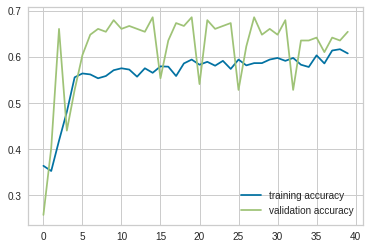

In [38]:
model_adam=buildingModel(optimizers[2])#optimizers = adam
nmodel_adam,model_df_adam=gpu(model_adam,epochs)
plotting(model_df_adam)

In [39]:
results=model_adam.evaluate(test_data_arr,test_label_arr)
predictions=model_adam.predict(test_data_arr)
discrete_predict_li_adam=discretePredictions(predictions)
print('\n\n\t\t ----- Classification Report -----')
print(classification_report(test_label_li,discrete_predict_li_adam,target_names=data_classes))
print('\n\nConfusion Matrix Individual for Each class')
print(multilabel_confusion_matrix(test_label_li,discrete_predict_li_adam))

2/2 [==============================] - 0s 4ms/step - loss: 0.8733 - accuracy: 0.5833


		 ----- Classification Report -----
              precision    recall  f1-score   support

    melanoma       0.41      0.58      0.48        12
       nevus       0.43      0.25      0.32        12
         seb       0.92      0.92      0.92        12

    accuracy                           0.58        36
   macro avg       0.59      0.58      0.57        36
weighted avg       0.59      0.58      0.57        36



Confusion Matrix Individual for Each class
[[[14 10]
  [ 5  7]]

 [[20  4]
  [ 9  3]]

 [[23  1]
  [ 1 11]]]


**ADAGRAD**

Epoch 1/40
36/36 [==============================] - 7s 198ms/step - loss: 1.0979 - accuracy: 0.3340 - val_loss: 1.1013 - val_accuracy: 0.2579
Epoch 2/40
36/36 [==============================] - 7s 196ms/step - loss: 1.0976 - accuracy: 0.3347 - val_loss: 1.1011 - val_accuracy: 0.2579
Epoch 3/40
36/36 [==============================] - 7s 202ms/step - loss: 1.0971 - accuracy: 0.3340 - val_loss: 1.1009 - val_accuracy: 0.2579
Epoch 4/40
36/36 [==============================] - 7s 197ms/step - loss: 1.0972 - accuracy: 0.3340 - val_loss: 1.1007 - val_accuracy: 0.2579
Epoch 5/40
36/36 [==============================] - 7s 196ms/step - loss: 1.0968 - accuracy: 0.3354 - val_loss: 1.1004 - val_accuracy: 0.2579
Epoch 6/40
36/36 [==============================] - 7s 194ms/step - loss: 1.0968 - accuracy: 0.3340 - val_loss: 1.1002 - val_accuracy: 0.2516
Epoch 7/40
36/36 [==============================] - 7s 194ms/step - loss: 1.0962 - accuracy: 0.3298 - val_loss: 1.1000 - val_accuracy: 0.2642
Epoch 

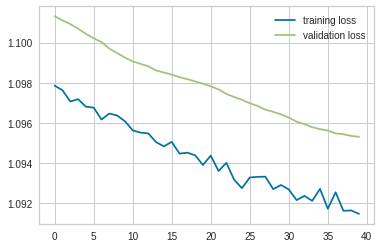

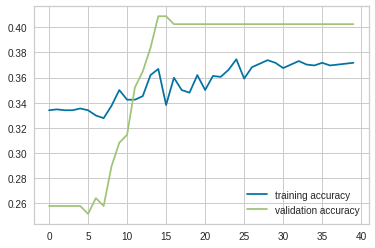

In [40]:
model_adagrad=buildingModel(optimizers[3])#optimizers = adagrad
nmodel_adagrad,model_df_adagrad=gpu(model_adagrad,epochs)
plotting(model_df_adagrad)

In [42]:
results=model_adagrad.evaluate(test_data_arr,test_label_arr)
predictions=model_adagrad.predict(test_data_arr)
discrete_predict_li_adagrad=discretePredictions(predictions)
print('\n\n\t\t ----- Classification Report -----')
print(classification_report(test_label_li,discrete_predict_li_adagrad,target_names=data_classes))
print('\n\nConfusion Matrix Individual for Each class')
print(multilabel_confusion_matrix(test_label_li,discrete_predict_li_adagrad))

2/2 [==============================] - 0s 5ms/step - loss: 1.0978 - accuracy: 0.3333


		 ----- Classification Report -----
              precision    recall  f1-score   support

    melanoma       0.33      1.00      0.50        12
       nevus       0.00      0.00      0.00        12
         seb       0.00      0.00      0.00        12

    accuracy                           0.33        36
   macro avg       0.11      0.33      0.17        36
weighted avg       0.11      0.33      0.17        36



Confusion Matrix Individual for Each class
[[[ 0 24]
  [ 0 12]]

 [[24  0]
  [12  0]]

 [[24  0]
  [12  0]]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**ADADELTA**

Epoch 1/40
36/36 [==============================] - 7s 199ms/step - loss: 1.0984 - accuracy: 0.3564 - val_loss: 1.0979 - val_accuracy: 0.4025
Epoch 2/40
36/36 [==============================] - 7s 195ms/step - loss: 1.0982 - accuracy: 0.3578 - val_loss: 1.0979 - val_accuracy: 0.4025
Epoch 3/40
36/36 [==============================] - 7s 194ms/step - loss: 1.0983 - accuracy: 0.3585 - val_loss: 1.0979 - val_accuracy: 0.4025
Epoch 4/40
36/36 [==============================] - 7s 196ms/step - loss: 1.0981 - accuracy: 0.3676 - val_loss: 1.0978 - val_accuracy: 0.4025
Epoch 5/40
36/36 [==============================] - 7s 194ms/step - loss: 1.0981 - accuracy: 0.3753 - val_loss: 1.0978 - val_accuracy: 0.4025
Epoch 6/40
36/36 [==============================] - 7s 194ms/step - loss: 1.0982 - accuracy: 0.3529 - val_loss: 1.0978 - val_accuracy: 0.4025
Epoch 7/40
36/36 [==============================] - 7s 194ms/step - loss: 1.0983 - accuracy: 0.3725 - val_loss: 1.0978 - val_accuracy: 0.4025
Epoch 

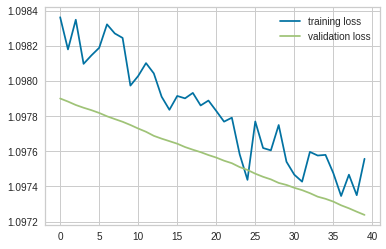

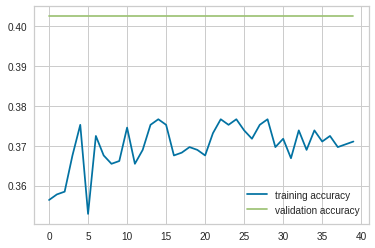

In [43]:
model_adadelta=buildingModel(optimizers[4])#optimizers = adadelta
nmodel_adadelta,model_df_adadelta=gpu(model_adadelta,epochs)
plotting(model_df_adadelta)

In [45]:
results=model_adadelta.evaluate(test_data_arr,test_label_arr)
predictions=model_adadelta.predict(test_data_arr)
discrete_predict_li_adadelta=discretePredictions(predictions)
print('\n\n\t\t ----- Classification Report -----')
print(classification_report(test_label_li,discrete_predict_li_adadelta,target_names=data_classes))
print('\n\nConfusion Matrix Individual for Each class')
print(multilabel_confusion_matrix(test_label_li,discrete_predict_li_adadelta))

2/2 [==============================] - 0s 5ms/step - loss: 1.0982 - accuracy: 0.3333


		 ----- Classification Report -----
              precision    recall  f1-score   support

    melanoma       0.33      1.00      0.50        12
       nevus       0.00      0.00      0.00        12
         seb       0.00      0.00      0.00        12

    accuracy                           0.33        36
   macro avg       0.11      0.33      0.17        36
weighted avg       0.11      0.33      0.17        36



Confusion Matrix Individual for Each class
[[[ 0 24]
  [ 0 12]]

 [[24  0]
  [12  0]]

 [[24  0]
  [12  0]]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
